# Een dataframe verkennen
## Business vraag
Welke producten die in België verkocht worden, bevatten Vitamine D en waar worden die verkocht?
## Download de data
Wanneer we de data downloaden, krijgen we een zipbestand dat we kunnen uitpakken. 

In [2]:
from pathlib import Path
import requests
FOOD_ZIP = 'food_facts.zip'
food_path = Path(FOOD_ZIP)
if not food_path.exists():
    data = requests.get('https://www.kaggle.com/api/v1/datasets/download/openfoodfacts/world-food-facts')
    with open(FOOD_ZIP, mode='wb') as f:
        f.write(data.content)
else:
    print(f"Bestand {FOOD_ZIP} is al gedownload")

Bestand food_facts.zip is al gedownload


In [5]:
from pathlib import Path
from zipfile import ZipFile
FOOD_TSV = 'en.openfoodfacts.org.products.tsv'
food_tsv_path = Path(FOOD_TSV)
if not food_tsv_path.exists():
    with open(FOOD_ZIP, mode='rb') as f:
        ZipFile(f).extractall()
else:
    print(f"Bestand {FOOD_TSV} bestaat al")

Bestand en.openfoodfacts.org.products.tsv bestaat al


## Wat voor bestand is het
Ik vind het een goed idee om de eerste regels met Python te lezen. Hier zien we dat het een .tsv-bestand is: een tab-separated-values bestand (dat hadden we ook kunnen zien aan de extensie natuurlijk)

In [24]:
FOOD_TSV = 'en.openfoodfacts.org.products.tsv'
with open(FOOD_TSV) as f:
    for _ in range(5):
        print(f.readline(), end='')

code	url	creator	created_t	created_datetime	last_modified_t	last_modified_datetime	product_name	generic_name	quantity	packaging	packaging_tags	brands	brands_tags	categories	categories_tags	categories_en	origins	origins_tags	manufacturing_places	manufacturing_places_tags	labels	labels_tags	labels_en	emb_codes	emb_codes_tags	first_packaging_code_geo	cities	cities_tags	purchase_places	stores	countries	countries_tags	countries_en	ingredients_text	allergens	allergens_en	traces	traces_tags	traces_en	serving_size	no_nutriments	additives_n	additives	additives_tags	additives_en	ingredients_from_palm_oil_n	ingredients_from_palm_oil	ingredients_from_palm_oil_tags	ingredients_that_may_be_from_palm_oil_n	ingredients_that_may_be_from_palm_oil	ingredients_that_may_be_from_palm_oil_tags	nutrition_grade_uk	nutrition_grade_fr	pnns_groups_1	pnns_groups_2	states	states_tags	states_en	main_category	main_category_en	image_url	image_small_url	energy_100g	energy-from-fat_100g	fat_100g	saturated-fat_100g	-buty

## Data inlezen met pandas
We geven als delimiter '\t' mee. Bij het inlezen krijgen we een warning. Pandas heeft geprobeerd om de datatypes te 'raden'. Maar omdat het een heel groot bestand is, geven we de types best zelf mee. Om voor elke kolom de datatypes te kennen, moet het volledige bestand eerst worden ingelezen. Pas dan is het datatype gekend. En dat vraag veel meer geheugen.  

In [7]:
import pandas as pd
FOOD_TSV = 'en.openfoodfacts.org.products.tsv'
df = pd.read_csv(FOOD_TSV, delimiter='\t', index_col='code')
df.head()

C:\Users\Jef\AppData\Local\Temp\ipykernel_6308\2777393571.py:3: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FOOD_TSV, delimiter='\t', index_col='code')


,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
code,,,,,,,,,,,,,,,,,,,,,
3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Hoeveel rijen zijn er?
De shape van een dataframe bevat het aantal rijen en kolommen. (denk aan NumPy)

In [8]:
df.shape[0]

356027

## Welke kolommen hebben we?
Met de info()-functie kunnen we informatie opvragen over het dataframe, maar in dit geval is de informatie zo uitgebreid (163 kolommen) dat we niets te zien krijgen.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


## .info(verbose=True)
Met het argument 'verbose' kunnen we meer informatie zien. (kies: 'view as scrollable element'). 

In [77]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 356027 entries, 3087 to 999990026839
Data columns (total 162 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    url                                         object 
 1    creator                                     object 
 2    created_t                                   object 
 3    created_datetime                            object 
 4    last_modified_t                             object 
 5    last_modified_datetime                      object 
 6    product_name                                object 
 7    generic_name                                object 
 8    quantity                                    object 
 9    packaging                                   object 
 10   packaging_tags                              object 
 11   brands                                      object 
 12   brands_tags                                 object 
 13   categori

## We vertrekken van een Business vraag
Welke voedingsmiddelen in België bevatten vitamine d ? Welke kolommen hebben we daarvoor nodig? 
countries_en, product_name, brands, stores, vitamin-d_100g. We geven meteen ook de types mee. (let op het type voor Code.)


In [2]:
import pandas as pd
FOOD_TSV = 'en.openfoodfacts.org.products.tsv'
df_data = pd.read_csv(FOOD_TSV, delimiter='\t', index_col='code', 
                      usecols=['code', 'countries_en', 'product_name','brands', 'stores', 'vitamin-d_100g'],
                      dtype={'code':pd.StringDtype(), 'countries_en':pd.StringDtype(), 
                             'product_name':pd.StringDtype(), 'brands':pd.StringDtype(),
                             'stores':pd.StringDtype(),'vitamin-d_100g':pd.Float64Dtype()})
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356027 entries, 0000000003087 to 999990026839
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   product_name    338515 non-null  string 
 1   brands          326977 non-null  string 
 2   stores          57701 non-null   string 
 3   countries_en    355752 non-null  string 
 4   vitamin-d_100g  7207 non-null    Float64
dtypes: Float64(1), string(4)
memory usage: 16.6+ MB


## Filter NA-waarden voor 'countries_en' en 'vitamin-d_100g'
Aangezien we op zoek zijn naar waarden voor Belgium  en vitamine D heeft het niet veel zin om records met lege waarden voor deze kolommen te behouden. We zullen die verwijderen. Hiervoor kunnen we .dropna() gebruiken. We beperken de controle tot de kolommen *countries_en* en *vitamin-d_100g*.


In [3]:
df_data = df_data.dropna(subset=['countries_en', 'vitamin-d_100g'])
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7206 entries, 0000111301201 to 9556001092533
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_name    7151 non-null   string 
 1   brands          7116 non-null   string 
 2   stores          612 non-null    string 
 3   countries_en    7206 non-null   string 
 4   vitamin-d_100g  7206 non-null   Float64
dtypes: Float64(1), string(4)
memory usage: 344.8+ KB


## Hoe ziet de countries_en kolom er uit?
Bevat die kolom 1 landnaam of meerdere?

In [20]:
pd.set_option('display.max_rows', 100) # 100 is de standaardwaarde maar we kunnen dit wijzigen
for item in df_data['countries_en']:
    print(item)


United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United States
United

## Worden alle producten alleen in Belgie verkocht?
In NumPy hebben we np.strings om de gevectoriseerde string-functies te gebruiken. In Pandas hebben we iets gelijkaardig via DataFrame.str.

We kunnen nu uitzoeken of België altijd alleen voorkomt of soms ook in combinatie met anderen landen?

In [4]:
alleen_belgie = df_data[df_data['countries_en']=='Belgium']
belgie_gecombineerd = df_data[df_data['countries_en'].str.contains('Belgium')]
print(len(alleen_belgie))
print(len(belgie_gecombineerd))

13
39


## We willen alleen producten overhouden met waarden België
We werken verder met de filter belgie_gecombineerd 


In [5]:
df_data = df_data[df_data['countries_en'].str.contains('Belgium')]

df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 06401612 to 8722700247975
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_name    37 non-null     string 
 1   brands          39 non-null     string 
 2   stores          19 non-null     string 
 3   countries_en    39 non-null     string 
 4   vitamin-d_100g  39 non-null     Float64
dtypes: Float64(1), string(4)
memory usage: 1.9+ KB


## Wat zijn de productnamen voor die 39 producten en wie verkoopt ze?
We zullen de gegevens sorteren op basis van 'vitamin-d_100g' (van groot naar klein). De iterator voor de dataset krijgen we met iterrows. Die geeft (index, rij) terug:

In [6]:
for _, merk in df_data.loc[:, ['product_name', 'brands', 'stores', 'vitamin-d_100g']].sort_values('vitamin-d_100g', ascending=False).iterrows():
    print(merk.at['product_name'], merk.at['brands'], merk.at['stores'],merk.at['vitamin-d_100g'])

Nesquik® 450 g Nesquik,Nestlé Leclerc 1.1e-05
Nesquik Nestlé,Nesquik Cora 1.1e-05
Nesquik (family pack) Nestlé,Nesquik <NA> 1.1e-05
Nesquick Nestle <NA> 1.1e-05
Margarine Bertolli <NA> 7.5e-06
Bertoli Bertoli <NA> 7.5e-06
Planta Planta <NA> 7.5e-06
Margarine végétale  Solo,Unilever Delhaize 7.5e-06
Becel Becel Delhaize 7.5e-06
Planta au beurre au sel marin planta <NA> 7.5e-06
Becel pro-activ Becel DELHAIZE 7.5e-06
Becel Cuire et Rôtir Light Becel <NA> 6.8e-06
Soja à tartiner Alpro Colruyt 6e-06
Special K nourish - myrtilles, mûres, framboises & groseilles Kellogg's,Special K,Nourrish Leclerc,E.Leclerc,Intermarché,Auchan,Carrefour 5.3e-06
Special K HOT 3 céréales Original Kellogg's Carrefour 4.7e-06
Spécial K Hot 3 céréales Fruits rouges Kellogg's <NA> 4.7e-06
Coco Pops Kellogg's,Coco Pops Carrefour,Carrefour City 4.2e-06
Coco Pops Chocos Kellogg's,Coco Pops <NA> 4.2e-06
Corn Flakes Kellogg's <NA> 4.2e-06
Frosties  Kellogg's <NA> 4.2e-06
<NA> Kellogg's <NA> 4.2e-06
Nesquik Duo Nestlé,Ne

## Conclusie
Blijkbaar zit er 'relatief veel' vitamine d in Nesquik. We kunnen dit plotten in een horizontale barchart. Omdat de aantallen verschillen in de grootte-orde van machten van 10, gebruiken we een log-schaal.

Om de 10 hoogste waarden te pakken te krijgen, vragen we eerst de indexen op van die waarden. Vervolgens gebruiken we dat om de productnaam en het vitamine D gehalte over te houden. 

We gebruiken *gca().invert_yaxis()* (*gca=get current axes*) om de waarden van groot naar klein te tonen. 

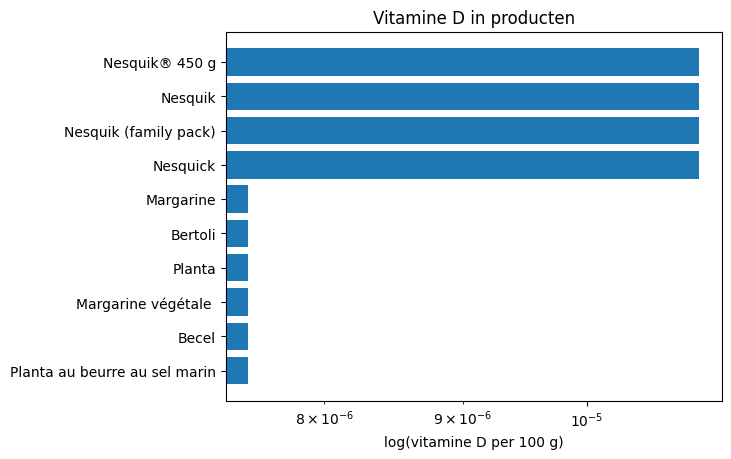

In [11]:
import matplotlib.pyplot as plt
indexen = df_data.sort_values(by='vitamin-d_100g', ascending=False).index[:10]
plt_data = df_data.loc[indexen, ['product_name', 'vitamin-d_100g']]
plt.barh(plt_data['product_name'], plt_data['vitamin-d_100g'], log=True)
plt.xlabel('log(vitamine D per 100 g)')
plt.gca().invert_yaxis()
plt.title('Vitamine D in producten')
plt.show()